# Step 4 — Topic Modeling

**Goal:** Discover common themes/topics in the cleaned Reddit corpus.

**What this notebook does**

- Loads `cleaned datasets`.
- Builds document-term matrices with chosen preprocessing.
- Trains topic models and tunes the number of topics (k).
- Interprets topics: top words per topic, example documents, and interactive or static visuals.
- Exports results for reporting: topic terms, document-topic assignments, and charts.

**Inputs:** `cleaned datasets`.  
**Outputs:**

- trained model
- document-topic matrix
- top words per topic


In [3]:
#
try:
    IS_PIPELINE_RUN
except NameError:
    IS_PIPELINE_RUN = False

try:
    IS_PIPELINE_TEST
except NameError:
    IS_PIPELINE_TEST = False

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
# Display settings
pd.set_option("display.max_colwidth", None)

# Load the dataset
dataset_folder = Path("../datasets")

# set filename path
if IS_PIPELINE_RUN:
    filename1 = "Palo_Alto_cleaned_pipeline_reddit.pkl"
else:
    filename1 = "Palo_Alto_cleaned_20251008_005822_reddit.pkl"

dataset_path = Path(dataset_folder / filename1)


print("Loading dataset from:", dataset_path)
if not dataset_path.exists():
    raise FileNotFoundError(f"❌ Dataset not found at: {dataset_path}")

# Load data
df = pd.read_pickle(dataset_path)
print("✅ Dataset loaded successfully.")
print("Shape:", df.shape)
# print(df.head(2))

Loading dataset from: ../datasets/Palo_Alto_cleaned_20251008_005822_reddit.pkl
✅ Dataset loaded successfully.
Shape: (79, 11)


Using 79 documents for topic modeling.
Document-term matrix shape: (79, 5499)

🟢 Topic 1:
people, like, nyc, sf, city, new, bay, area, good, covid

🟢 Topic 2:
like, people, think, women, scott, time, really, know, said, good

🟢 Topic 3:
people, like, kids, dont, years, want, im, time, think, housing

🟢 Topic 4:
bay, san, peninsula, area, city, people, like, think, mateo, lot

🟢 Topic 5:
school, students, like, schools, high, kids, people, college, make, years


/tmp/ipykernel_285119/2597249984.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="dominant_topic", data=df, palette="viridis")


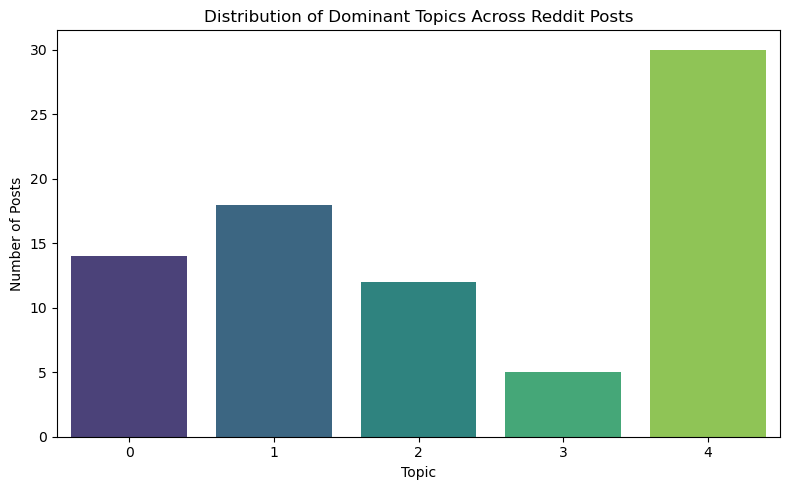


🧩 Topic 0 Example Posts:
Example 1: delete facebook delete ig delete whatsapp meta reprehensible business model bowed fascists faster anyone billionaire stops giving back communities given time stop funding buy groceries local farmers stop using social media zuckerberg used people pr social capital longer useful mission greed power dr...

Example 2: almost like shouldnt depend lords sweeping crumbs table almost like tax kids get schooling matter masks stop pretending werent always garbage people zuck threatening kick elons ass 6 months good pr fuck kids guess mark zuckerberg doctor pediatric medicine priscilla chan actual ghouls deleted faceboo...


🧩 Topic 1 Example Posts:
Example 1: almost schools funded public rather whims megarich something clout taxes think wife would better looks like they’re bird feather good know theyre pieces shit hope trump comes anyway appologize dumb question public school would receiving title 1 federal funding crazy whole school shut one guy stops f...



In [5]:
# Prepare text for topic modeling
# Combine all comments for each post into one text block
# df["doc_text"] = df["comments_flat"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
df["doc_text"] = df["cleaned_comments"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)
df = df[df["doc_text"].str.strip() != ""]
print(f"Using {len(df)} documents for topic modeling.")

# Vectorize text
vectorizer = CountVectorizer(
    max_df=0.9,  # ignore overly common words
    min_df=2,  # ignore rare words
    stop_words="english",
)
dtm = vectorizer.fit_transform(df["doc_text"])
print("Document-term matrix shape:", dtm.shape)


# LDA Topic Modeling
lda = LatentDirichletAllocation(
    n_components=5, random_state=42, learning_method="batch"  # number of topics
)
lda.fit(dtm)


# Display Top Words per Topic
def display_topics(model, feature_names, no_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\n🟢 Topic {idx + 1}:")
        print(
            ", ".join(
                [feature_names[i] for i in topic.argsort()[: -no_top_words - 1 : -1]]
            )
        )


feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, 10)


# Assign Dominant Topic to Each Post
topic_values = lda.transform(dtm)
df["dominant_topic"] = topic_values.argmax(axis=1)


# Plot Topic Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="dominant_topic", data=df, palette="viridis")
plt.title("Distribution of Dominant Topics Across Reddit Posts")
plt.xlabel("Topic")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()


# View Example Posts for Each Topic
for topic_num in sorted(df["dominant_topic"].unique()):
    print(f"\n🧩 Topic {topic_num} Example Posts:")
    sample_texts = df[df["dominant_topic"] == topic_num]["doc_text"].head(2).to_list()
    for i, text in enumerate(sample_texts, 1):
        print(f"Example {i}: {text[:300]}...\n")

## District Comparison via Topic Modeling


 Loaded datasets:
Palo Alto: (79, 11)  | Oklahoma City: (135, 11)
📘 Palo Alto posts: 79
📗 Oklahoma City posts: 135

🟦 Palo Alto Topics:


,Topic,Top Words
0,1,"people, like, nyc, sf, city, new, bay, area, good, covid"
1,2,"like, people, think, women, scott, time, really, know, said, good"
2,3,"people, like, kids, dont, years, want, im, time, think, housing"
3,4,"bay, san, peninsula, area, city, people, like, think, mateo, lot"
4,5,"school, students, like, schools, high, kids, people, college, make, years"



🟩 Oklahoma City Topics:


,Topic,Top Words
0,1,"like, team, game, year, think, nba, time, really, player, good"
1,2,"vote, people, like, florida, primary, voted, win, good, think, trump"
2,3,"like, people, work, job, years, atc, time, think, know, im"
3,4,"people, like, white, think, im, years, dont, money, need, home"
4,5,"people, like, dont, know, think, school, im, time, really, right"


/tmp/ipykernel_755914/3312971749.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x="dominant_topic", data=palo_df, palette="Blues")
/tmp/ipykernel_755914/3312971749.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x="dominant_topic", data=okc_df, palette="Greens")


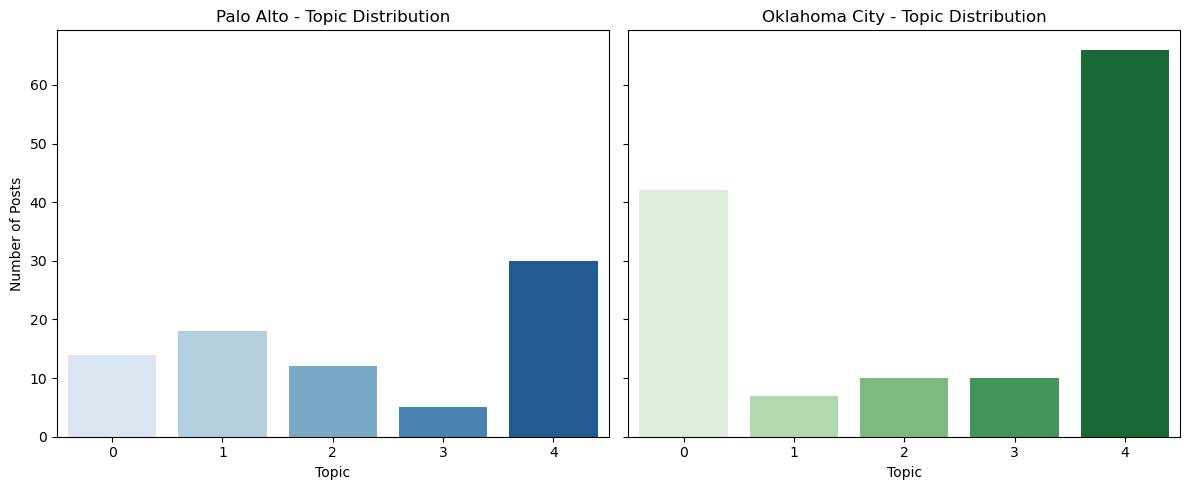

,District,Posts,Top Topic IDs
0,Palo Alto,79,4
1,Oklahoma City,135,4


In [6]:
# District Comparison via Topic Modeling
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

pd.set_option("display.max_colwidth", None)

if IS_PIPELINE_RUN:
    palo_filename = "Palo_Alto_cleaned_pipeline_reddit.pkl"
    okc_filename = "Oklahoma_City_cleaned_pipeline_reddit.pkl"
else:
    palo_filename = "Palo_Alto_cleaned_20251008_005822_reddit.pkl"
    okc_filename = "Oklahoma_City_cleaned_20251008_005822_reddit.pkl"

# Palo Alto and Oklahoma City Reddit data
palo_path = dataset_folder / palo_filename
okc_path = dataset_folder / okc_filename

palo_df = pd.read_pickle(palo_path)
okc_df = pd.read_pickle(okc_path)

print(" Loaded datasets:")
print("Palo Alto:", palo_df.shape, " | Oklahoma City:", okc_df.shape)


# Clean and prepare text data
def prepare_text(df):
    # df["doc_text"] = df["comments_flat"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
    df["doc_text"] = df["cleaned_comments"].apply(
        lambda x: " ".join(x) if isinstance(x, list) else str(x)
    )
    df = df[df["doc_text"].str.strip() != ""]
    return df


palo_df = prepare_text(palo_df)
okc_df = prepare_text(okc_df)

print(f"📘 Palo Alto posts: {len(palo_df)}")
print(f"📗 Oklahoma City posts: {len(okc_df)}")


# Define function for LDA topic modeling
def run_lda(df, n_topics=5, label="District"):
    vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
    dtm = vectorizer.fit_transform(df["doc_text"])

    lda = LatentDirichletAllocation(
        n_components=n_topics, random_state=42, learning_method="batch"
    )
    lda.fit(dtm)

    # Top words per topic
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
        topics.append({"Topic": idx + 1, "Top Words": ", ".join(top_words)})

    # Assign dominant topic to each post
    topic_values = lda.transform(dtm)
    df["dominant_topic"] = topic_values.argmax(axis=1)

    return df, pd.DataFrame(topics)


# Run topic modeling for each district
palo_df, palo_topics = run_lda(palo_df, label="Palo Alto")
okc_df, okc_topics = run_lda(okc_df, label="Oklahoma City")


# Display top words per topic
print("\n🟦 Palo Alto Topics:")
display(palo_topics)

print("\n🟩 Oklahoma City Topics:")
display(okc_topics)


# Compare topic distributions visually
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.countplot(ax=axes[0], x="dominant_topic", data=palo_df, palette="Blues")
axes[0].set_title("Palo Alto - Topic Distribution")
axes[0].set_xlabel("Topic")
axes[0].set_ylabel("Number of Posts")

sns.countplot(ax=axes[1], x="dominant_topic", data=okc_df, palette="Greens")
axes[1].set_title("Oklahoma City - Topic Distribution")
axes[1].set_xlabel("Topic")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


# Combined summary for reporting
summary = pd.DataFrame(
    {
        "District": ["Palo Alto", "Oklahoma City"],
        "Posts": [len(palo_df), len(okc_df)],
        "Top Topic IDs": [
            palo_df["dominant_topic"].value_counts().idxmax(),
            okc_df["dominant_topic"].value_counts().idxmax(),
        ],
    }
)

display(summary)

### Summary

The topic modeling showed that people in both Palo Alto and Oklahoma City talk a lot about schools, students, and education, but in different ways. Palo Alto posts often focus on things like college prep, housing, and competition in the Bay Area, while Oklahoma City posts talk more about school quality, student workload, and community issues. In short, both districts care about education, but their discussions reflect different local concerns and priorities.


## Sentiment Analysis + Word Clouds


In [7]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER
nltk.download("vader_lexicon")

# Initialize
sia = SentimentIntensityAnalyzer()

# Compute sentiment score for each post
df["sentiment_score"] = df["doc_text"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Label sentiment category
df["sentiment_label"] = df["sentiment_score"].apply(
    lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral")
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/junc/nltk_data...


/tmp/ipykernel_285119/780126870.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment_label", data=df, palette="coolwarm")


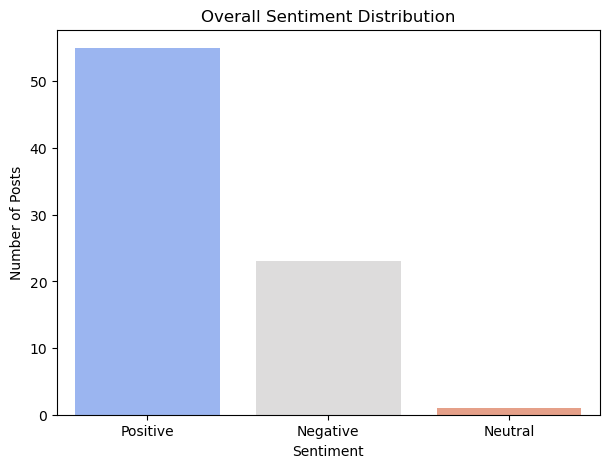

/tmp/ipykernel_285119/780126870.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="dominant_topic", y="sentiment_score", data=df, palette="viridis")


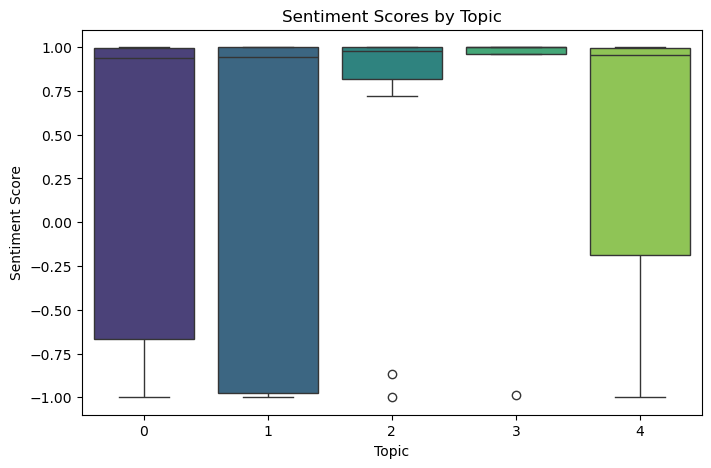

In [8]:
# Sentiment distribution overall
plt.figure(figsize=(7, 5))
sns.countplot(x="sentiment_label", data=df, palette="coolwarm")
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")
plt.show()

# Sentiment by dominant topic
plt.figure(figsize=(8, 5))
sns.boxplot(x="dominant_topic", y="sentiment_score", data=df, palette="viridis")
plt.title("Sentiment Scores by Topic")
plt.xlabel("Topic")
plt.ylabel("Sentiment Score")
plt.show()

In [9]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.7 MB/s  0:00:00


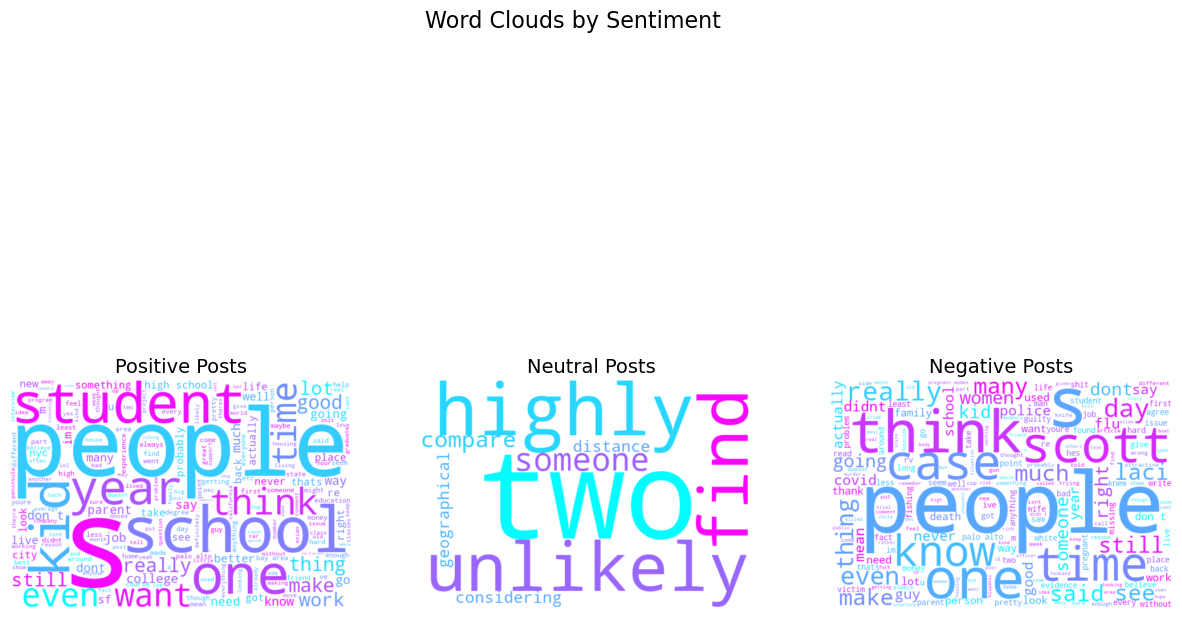

In [10]:
from wordcloud import WordCloud

# Generate word clouds for each sentiment
sentiments = ["Positive", "Neutral", "Negative"]
plt.figure(figsize=(15, 10))

for i, sentiment in enumerate(sentiments):
    text = " ".join(df[df["sentiment_label"] == sentiment]["doc_text"])
    wc = WordCloud(
        width=600, height=400, background_color="white", colormap="cool"
    ).generate(text)

    plt.subplot(1, 3, i + 1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment} Posts", fontsize=14)

plt.suptitle("Word Clouds by Sentiment", fontsize=16)
plt.show()